K-Means & GMM

In [1]:
import numpy as np
import pandas as pd
from copy import deepcopy
import random
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.special import comb

First Dataset

In [2]:
from sklearn.datasets import make_classification
X, Y = make_classification(n_samples=700, n_features=2,
                           n_informative=2, n_redundant=0,
                           n_classes=2)

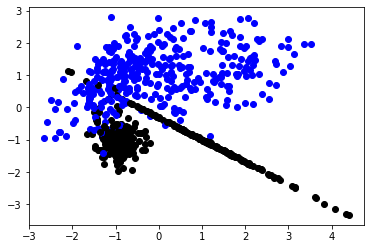

In [3]:
colors=['black', 'blue']
for i in range(X.shape[0]):
    plt.scatter(X[i, 0], X[i,1], color = colors[int(Y[i])])

In [4]:
def purity(target, pred):
    
    df_confusion = pd.crosstab(pd.Series(target, name='Target'), pd.Series(pred, name='Predicted'))
    confusion_matrix = df_confusion.to_numpy()
    
    return np.sum(np.amax(confusion_matrix, axis=0)) / np.sum(confusion_matrix)

def rand_index(clusters, classes):
    tpfp = comb(np.bincount(clusters), 2).sum()
    tpfn = comb(np.bincount(classes), 2).sum()
    A = np.c_[(clusters, classes)]
    tp = sum(comb(np.bincount(A[A[:, 0] == i, 1]), 2).sum() for i in set(clusters))
    fp = tpfp - tp
    fn = tpfn - tp
    tn = comb(len(A), 2) - tp - fp - fn
    return (tp + tn) / (tp + fp + fn + tn)

class Kmeans:
    def __init__ (self , K , X):
        self.K = K
        self.X = X
        self.centers = []
        
    def fit(self):
        
        centers_old = np.zeros((2,2))
        centers_new = X[random.sample(range(0, len(X)),2)]
        self.centers = centers_new
        dist = np.zeros((X.shape[0],self.K))
      
        while sorted(centers_new.tolist()) != sorted(centers_old.tolist()):
            
            for i in range(self.K):
                dist[:,i] = np.linalg.norm(X - self.centers[i], axis=1)
                
            clusters = np.argmin(dist, axis = 1)
            
            centers_old = deepcopy(centers_new)

            for i in range(self.K):
                centers_new[i] = np.mean(X[clusters == i], axis=0)
                
            self.centers = centers_new
         
        return clusters , centers_new

K-Means For First Dataset

K-Means Purity :  0.9028571428571428
K-Means Rand-Index :  0.8243368076844472
Final Centers :  [[-0.10111641 -0.92064518]
 [ 0.13668358  1.23611845]]


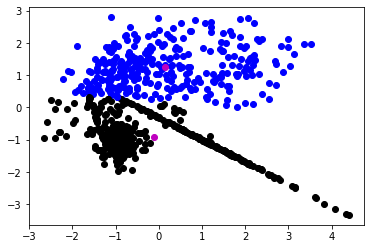

In [5]:
kmeans = Kmeans(2 , X)
preds , centers_new = kmeans.fit()

colors=['black', 'blue']
for i in range(X.shape[0]):
    plt.scatter(X[i, 0], X[i,1], color = colors[int(preds[i])])
    
plt.scatter(centers_new[:,0], centers_new[:,1], c='m')
print("K-Means Purity : " , purity(Y.tolist() , preds.tolist()))
print("K-Means Rand-Index : " , rand_index(Y.tolist() , preds.tolist()))
print("Final Centers : " , centers_new)

In [6]:
class GMM : 
    
    def E_step(self , X, K, means, covar , w):
    
        prob = np.zeros((X.shape[0],K))
    
        for i in range(len(X)):
            for k in range(0,K):
                prob[i , k] = w[k] * multivariate_normal.pdf(X[i], means[k,:], covar[k,:,:])
                    
            prob[i] /= sum(prob[i])
   
        return prob

    def M_step(self , X, K, means, covar , w, prob):
    
        N = np.zeros(prob.shape[1])
    
        for k in range(0,K):
            mean = 0
            N[k] = prob[:,k].sum(axis=0)
        
            for n in range(0,X.shape[0]):
                mean += prob[n,k]*X[n]
            
            means[k] = mean/N[k]
        
            cov = 0
            for n in range(0,X.shape[0]):
                xm = X[n] - means[k]
                cov += prob[n,k] * np.outer(xm , xm.T)
                     
            covar[k] = cov/N[k]
        
        w = N / N.sum(axis=0)
    
        return means, covar , w
    
    def log_likelihood(self ,X, means, covs, w):
    
        log_likelihood = 0
        for i in range(X.shape[0]):
            temp = 0
            for k in range(len(w)):
                temp += w[k] * multivariate_normal.pdf(X[i], mean=means[k], cov=covs[k])
            log_likelihood += np.log(temp)
    
        return log_likelihood

GMM For First Dataset

GMM Purity :  0.9185714285714286
GMM Rand-Index :  0.8501900674432863


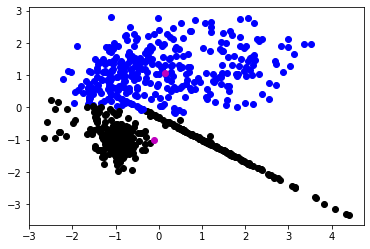

In [7]:
gmm = GMM()

K=2
w = np.array([0.5, 0.5])
# means = centers_new
means = np.array([[random.random() , random.random()] for _ in range(2)])
covar  = np.array([0.5 * np.eye(2), 0.5 * np.eye(2)])
old_log = 0
new_log = gmm.log_likelihood(X, means, covar , w)

while abs(old_log - new_log) > 0.1:
    old_log = new_log
    prob = gmm.E_step(X, K, means, covar , w)
    means, covar , w = gmm.M_step(X, K, means, covar , w, prob)
    new_log = gmm.log_likelihood(X, means, covar , w)

preds = []
for p in prob:
    preds.append(np.argmax(p))

colors=['black', 'blue']
for i in range(X.shape[0]):
    plt.scatter(X[i, 0], X[i,1], color = colors[int(preds[i])])

plt.scatter(centers_new[:,0], means[:,1], c='m')

print("GMM Purity : " , purity(Y.tolist() , preds))
print("GMM Rand-Index : " , rand_index(Y.tolist() , preds))

Second Dataset

In [16]:
from sklearn.datasets.samples_generator import make_moons
X, Y = make_moons(n_samples=700, noise=0.2)

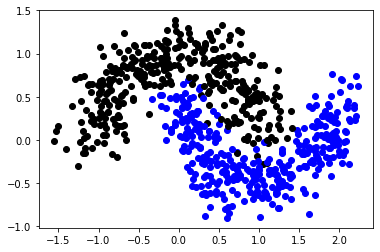

In [17]:
colors=['black', 'blue']
for i in range(X.shape[0]):
    plt.scatter(X[i, 0], X[i,1], color = colors[int(Y[i])])

K-Means For Second Dataset

K-Means Purity :  0.7671428571428571
K-Means Rand-Index :  0.6422194972409565
Final Centers :  [[ 1.16388184 -0.08226877]
 [-0.22829427  0.60463865]]


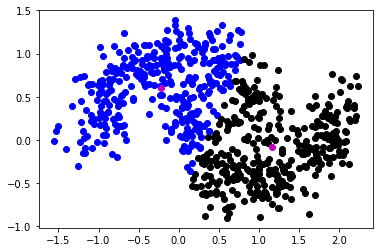

In [18]:
kmeans = Kmeans(2 , X)
preds , centers_new = kmeans.fit()

colors=['black', 'blue']
for i in range(X.shape[0]):
    plt.scatter(X[i, 0], X[i,1], color = colors[int(preds[i])])
    
plt.scatter(centers_new[:,0], centers_new[:,1], c='m')
print("K-Means Purity : " , purity(Y.tolist() , preds.tolist()))
print("K-Means Rand-Index : " , rand_index(Y.tolist() , preds.tolist()))
print("Final Centers : " , centers_new)

GMM For Second Dataset

GMM Purity :  0.84
GMM Rand-Index :  0.7308154506437768


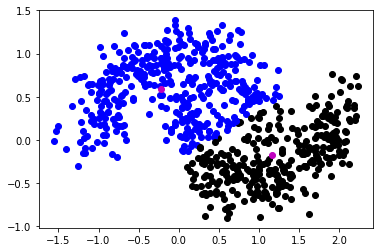

In [19]:
gmm = GMM()

K=2
w = np.array([0.5, 0.5])
# means = centers_new
means = np.array([[random.random() , random.random()] for _ in range(2)])
covar  = np.array([0.5 * np.eye(2), 0.5 * np.eye(2)])
old_log = 0
new_log = gmm.log_likelihood(X, means, covar , w)

while abs(old_log - new_log) > 0.1:
    old_log = new_log
    prob = gmm.E_step(X, K, means, covar , w)
    means, covar , w = gmm.M_step(X, K, means, covar , w, prob)
    new_log = gmm.log_likelihood(X, means, covar , w)

preds = []
for p in prob:
    preds.append(np.argmax(p))

colors=['black', 'blue']
for i in range(X.shape[0]):
    plt.scatter(X[i, 0], X[i,1], color = colors[int(preds[i])])

plt.scatter(centers_new[:,0], means[:,1], c='m')

print("GMM Purity : " , purity(Y.tolist() , preds))
print("GMM Rand-Index : " , rand_index(Y.tolist() , preds))

Third Dataset

In [12]:
from sklearn.datasets.samples_generator import make_circles
X, Y = make_circles(n_samples=700, noise=0.2)

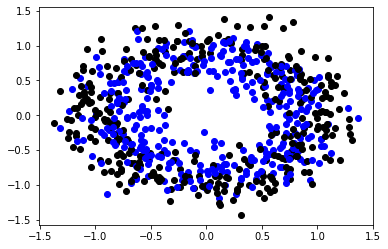

In [13]:
colors=['black', 'blue']
for i in range(X.shape[0]):
    plt.scatter(X[i, 0], X[i,1], color = colors[int(Y[i])])

K-Means For Third Dataset

K-Means Purity :  0.5171428571428571
K-Means Rand-Index :  0.4998732883711424
Final Centers :  [[-0.31702421  0.4989724 ]
 [ 0.33256884 -0.4918637 ]]


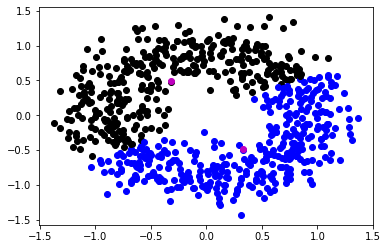

In [14]:
kmeans = Kmeans(2 , X)
preds , centers_new = kmeans.fit()

colors=['black', 'blue']
for i in range(X.shape[0]):
    plt.scatter(X[i, 0], X[i,1], color = colors[int(preds[i])])
    
plt.scatter(centers_new[:,0], centers_new[:,1], c='m')
print("K-Means Purity : " , purity(Y.tolist() , preds.tolist()))
print("K-Means Rand-Index : " , rand_index(Y.tolist() , preds.tolist()))
print("Final Centers : " , centers_new)

GMM For Third Dataset

GMM Purity :  0.5085714285714286
GMM Rand-Index :  0.4994318414060903


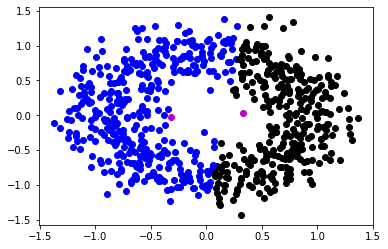

In [15]:
gmm = GMM()

K=2
w = np.array([0.5, 0.5])
# means = centers_new   #we can set means to final centers that was found by K-means If We Want
means = np.array([[random.random() , random.random()] for _ in range(2)])
covar  = np.array([0.5 * np.eye(2), 0.5 * np.eye(2)])
old_log = 0
new_log = gmm.log_likelihood(X, means, covar , w)

while abs(old_log - new_log) > 0.1:
    old_log = new_log
    prob = gmm.E_step(X, K, means, covar , w)
    means, covar , w = gmm.M_step(X, K, means, covar , w, prob)
    new_log = gmm.log_likelihood(X, means, covar , w)

preds = []
for p in prob:
    preds.append(np.argmax(p))

colors=['black', 'blue']
for i in range(X.shape[0]):
    plt.scatter(X[i, 0], X[i,1], color = colors[int(preds[i])])

plt.scatter(centers_new[:,0], means[:,1], c='m')

print("GMM Purity : " , purity(Y.tolist() , preds))
print("GMM Rand-Index : " , rand_index(Y.tolist() , preds))